In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import trange, tqdm

torch.__version__

'1.2.0'

In [2]:
transform = transforms.Compose([#transforms.Resize((1,10000)),
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '..\\Assignment#2\\horse-or-human\\train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# print(trainset)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = '..\\Assignment#2\\horse-or-human\\validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)

In [3]:
train_data = np.zeros((10000, 0))
train_label = np.zeros((0,1))
val_data = np.zeros((10000,0))
val_label = np.zeros((0,1))

# load training images of the batch size for every iteration
for i, data in enumerate(trainloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    train_data = np.hstack((train_data, np.reshape(inputs, (10000,1))))
    
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    train_label = np.append(train_label, labels)

train_label = train_label.reshape(1,1027)


# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data

    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    val_data = np.hstack((val_data, np.reshape(inputs, (10000,1))))

    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    val_label = np.append(val_label, labels)

val_label = val_label.reshape(1,256)


print("train_label shape : " + str(train_label.shape))
print("train_data  shape : " + str(train_data.shape))
print("val_label   shape : " + str(val_label.shape))
print("val_label   shape : " + str(val_data.shape))

train_label shape : (1, 1027)
train_data  shape : (10000, 1027)
val_label   shape : (1, 256)
val_label   shape : (10000, 256)


In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


def calcAcc(hyphothesis, data_label, x):
    correct = 0
    for idx, hyp in enumerate(hyphothesis) :
        if hyp >= x and data_label[idx] == 1 :
            correct += 1
        elif hyp < x and data_label[idx] == 0 :
            correct += 1
    
    return correct / len(hyphothesis)


def isConvergence(epoch_num,losses, num=10, EPSILON=0.000000000000000000000000001, after=1000):
    if epoch_num < after :
        return False
    
    check_list = losses[-num:]
    check_list2 = losses[-num-1: -1]
    new_check_list = [ax - bx for ax, bx in zip(check_list, check_list2)]

    for elem in new_check_list :
        if elem > EPSILON :
            return False
    return True


In [ ]:
# INITIALIZE VARIABLES, EPOCH, LEARNING RATE, NUMBER OF NODES IN HIDDEN LAYER
LEARNING_RATE = 0.015
NUM_EPOCH = 100000
NUM_HIDDEN_LAYER_1 = 5
NUM_HIDDEN_LAYER_2 = 3

SMALL_LAMBDA = 0.0001
LAMBDA = 0.0005
LARGE_LAMBDA = 0.004775


NUM_TRAIN_DATA = train_data.shape[1]
NUM_VAL_DATA = val_data.shape[1]
IMAGE_VECTOR_LEN = train_data.shape[0]

In [14]:
w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

# b_1 = np.random.randn(NUM_HIDDEN_LAYER_1,1) * 0.01
# b_2 = np.random.randn(NUM_HIDDEN_LAYER_2, 1) * 0.01
# b_3 = np.random.randn(1, 1) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

In [15]:
for i in trange(NUM_EPOCH, desc="EPOCH"):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) * A_2 * (1-A_2)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * A_1 * (1-A_1)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_TRAIN_DATA + LARGE_LAMBDA/2 * (np.sum(w_1**2) + np.sum(w_2**2) + np.sum(w_3**2))
    train_loss.append(J)
    
    # FOR CALCULATING TRAIN ACCURACY
    train_accuracy.append(calcAcc(A_3[0], train_label[0], 0.5))
    
    # UPDATE PARAMETERS
    w_1 = (1 - LEARNING_RATE * LARGE_LAMBDA/2) * w_1 - LEARNING_RATE * dw_1
    w_2 = (1 - LEARNING_RATE * LARGE_LAMBDA/2) * w_2 - LEARNING_RATE * dw_2
    w_3 = (1 - LEARNING_RATE * LARGE_LAMBDA/2) * w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA + LARGE_LAMBDA/2 * (np.sum(w_1**2) + np.sum(w_2**2) + np.sum(w_3**2))
    val_loss.append(J)
    
    # FOR CALCULATING VALIDATION ACCURACY
    val_accuracy.append(calcAcc(A_3[0], val_label[0], 0.5))
    
#     if isConvergence(i, train_loss):
#         break

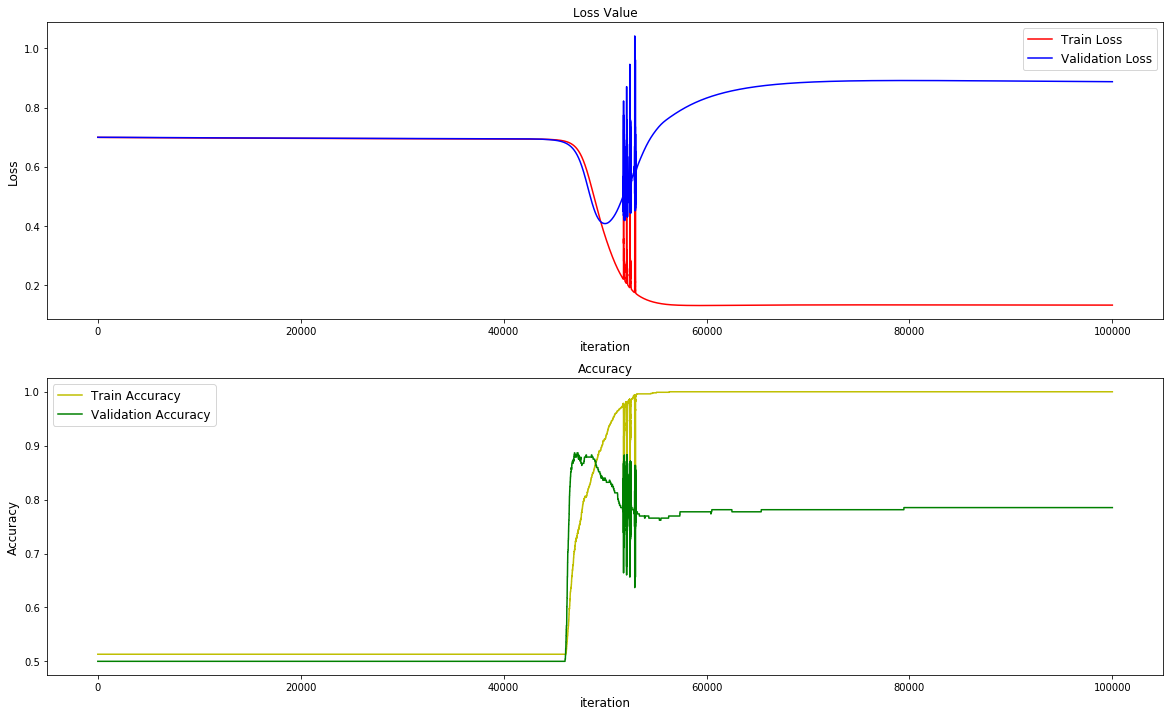

In [18]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION

fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(range(1, len(train_loss)+1), train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(val_loss)+1), val_loss, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(range(1, len(train_accuracy)+1), train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(val_accuracy)+1), val_accuracy, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

## Bias (large λ)

| dataset | loss | accuracy |
| -- | -- | -- |
| training | {{ train_loss[-1] }} | {{ train_accuracy[-1] }} |
| validation | {{ val_loss[-1] }} | {{ val_accuracy[-1] }} |

In [ ]:
w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

# b_1 = np.random.randn(NUM_HIDDEN_LAYER_1,1) * 0.01
# b_2 = np.random.randn(NUM_HIDDEN_LAYER_2, 1) * 0.01
# b_3 = np.random.randn(1, 1) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

In [ ]:
for i in trange(NUM_EPOCH, desc="EPOCH"):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) * A_2 * (1-A_2)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * A_1 * (1-A_1)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_TRAIN_DATA + SMALL_LAMBDA/2 * (np.sum(w_1**2) + np.sum(w_2**2) + np.sum(w_3**2))
    train_loss.append(J)
    
    # FOR CALCULATING TRAIN ACCURACY
    train_accuracy.append(calcAcc(A_3[0], train_label[0], 0.5))
    
    # UPDATE PARAMETERS
    w_1 = (1 - LEARNING_RATE * SMALL_LAMBDA/2) * w_1 - LEARNING_RATE * dw_1
    w_2 = (1 - LEARNING_RATE * SMALL_LAMBDA/2) * w_2 - LEARNING_RATE * dw_2
    w_3 = (1 - LEARNING_RATE * SMALL_LAMBDA/2) * w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA + SMALL_LAMBDA/2 * (np.sum(w_1**2) + np.sum(w_2**2) + np.sum(w_3**2))
    val_loss.append(J)
    
    # FOR CALCULATING VALIDATION ACCURACY
    val_accuracy.append(calcAcc(A_3[0], val_label[0], 0.5))
    
#     if isConvergence(i, train_loss):
#         break

In [ ]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION

fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(range(1, len(train_loss)+1), train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(val_loss)+1), val_loss, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(range(1, len(train_accuracy)+1), train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(val_accuracy)+1), val_accuracy, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

## Variance (small λ)
| dataset | loss | accuracy |
| -- | -- | -- |
| training | {{ train_loss[-1] }} | {{ train_accuracy[-1] }} |
| validation | {{ val_loss[-1] }} | {{ val_accuracy[-1] }} |

In [ ]:
w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

# b_1 = np.random.randn(NUM_HIDDEN_LAYER_1,1) * 0.01
# b_2 = np.random.randn(NUM_HIDDEN_LAYER_2, 1) * 0.01
# b_3 = np.random.randn(1, 1) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

In [ ]:
for i in trange(NUM_EPOCH, desc="EPOCH"):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) * A_2 * (1-A_2)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * A_1 * (1-A_1)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_TRAIN_DATA + LAMBDA/2 * (np.sum(w_1**2) + np.sum(w_2**2) + np.sum(w_3**2))
    train_loss.append(J)
    
    # FOR CALCULATING TRAIN ACCURACY
    train_accuracy.append(calcAcc(A_3[0], train_label[0], 0.5))
    
    # UPDATE PARAMETERS
    w_1 = (1 - LEARNING_RATE * LAMBDA/2) * w_1 - LEARNING_RATE * dw_1
    w_2 = (1 - LEARNING_RATE * LAMBDA/2) * w_2 - LEARNING_RATE * dw_2
    w_3 = (1 - LEARNING_RATE * LAMBDA/2) * w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA + LAMBDA/2 * (np.sum(w_1**2) + np.sum(w_2**2) + np.sum(w_3**2))
    val_loss.append(J)
    
    # FOR CALCULATING VALIDATION ACCURACY
    val_accuracy.append(calcAcc(A_3[0], val_label[0], 0.5))
    
#     if isConvergence(i, train_loss):
#         break

In [ ]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION

fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(range(1, len(train_loss)+1), train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(val_loss)+1), val_loss, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(range(1, len(train_accuracy)+1), train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(val_accuracy)+1), val_accuracy, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

## Best Generalization (appropriate λ)
| dataset | loss | accuracy |
| -- | -- | -- |
| training | {{ train_loss[-1] }} | {{ train_accuracy[-1] }} |
| validation | {{ val_loss[-1] }} | {{ val_accuracy[-1] }} |